The dataset folder encompasses a variety of variables related to urban conditions, including air quality, traffic, weather, and other socio-economic factors to support the development of IoT-driven predictive models. The features include categorical, numerical, and boolean types, and any missing values appear as empty strings. The goal is to predict total daily_ktCO2as the target variable for this competition.

It contains a datatrain.csv with training data for each feature, a datatest.csv with evaluation data for each feature, and a submission.csv file that provides the structure for submitting the overall predicted daily_ktCO2.

In [1]:
!pip install catboost
!pip install memory_profiler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from google.colab import files
from typing import Optional, List, Tuple

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer # Import FunctionTransformer
from sklearn.decomposition import PCA

# Models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor # Import StackingRegressor
from sklearn.linear_model import LinearRegression # Import LinearRegression
from sklearn.pipeline import make_pipeline # Import make_pipeline
from memory_profiler import memory_usage

# Deep Learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Tuning
from sklearn.model_selection import GridSearchCV

# Evaluating
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/teresatendeas/statsday2025/refs/heads/main/datatrain.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/teresatendeas/statsday2025/refs/heads/main/datatest.csv")

In [4]:
print(df.info(), df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   obs_id                         1606 non-null   int64  
 1   date                           1606 non-null   object 
 2   daily_ktCO2                    1606 non-null   float64
 3   pm25                           1604 non-null   float64
 4   pm10                           1604 non-null   float64
 5   o3                             1604 non-null   float64
 6   no2                            1580 non-null   float64
 7   so2                            331 non-null    object 
 8   env_index                      1606 non-null   float64
 9   Car_7-9                        310 non-null    float64
 10  Van_7-9                        310 non-null    float64
 11  Bus_7-9                        310 non-null    float64
 12  Minibus_7-9                    310 non-null    f

In [5]:
print("Shape:", df.shape)


Shape: (1606, 60)


# 1. Data Cleaning

## 1.1 Handling Missing Data

### 1.1.1 Numerical Data

#### 1.1.1.1 Remove unimportant columns

In [6]:
always_drop = ['obs_id']
df.drop(columns=always_drop, inplace=True)
df2.drop(columns=always_drop, inplace=True)

#### 1.1.1.2 Remove columns with 70% missing data

In [7]:
# Hitung rasio missing per kolom
missing_ratio = df.isna().mean()

high_missing_cols = missing_ratio[missing_ratio > 0.7].index.tolist()
high_missing_cols.remove('avg_ridership_monthly')
print("Kolom dengan >70% missing:", high_missing_cols)

df.drop(columns=high_missing_cols, inplace=True)
df2.drop(columns=high_missing_cols, inplace=True)

Kolom dengan >70% missing: ['so2', 'Car_7-9', 'Van_7-9', 'Bus_7-9', 'Minibus_7-9', 'Truck_7-9', '3Cycle_7-9', 'Car_9-17', 'Van_9-17', 'Bus_9-17', 'Minibus_9-17', 'Truck_9-17', '3Cycle_9-17', 'Car_17-19', 'Van_17-19', 'Bus_17-19', 'Minibus_17-19', 'Truck_17-19', '3Cycle_17-19', 'avg_ridership_workday_monthly']


#### 1.1.1.3 Remove columns with high correlation

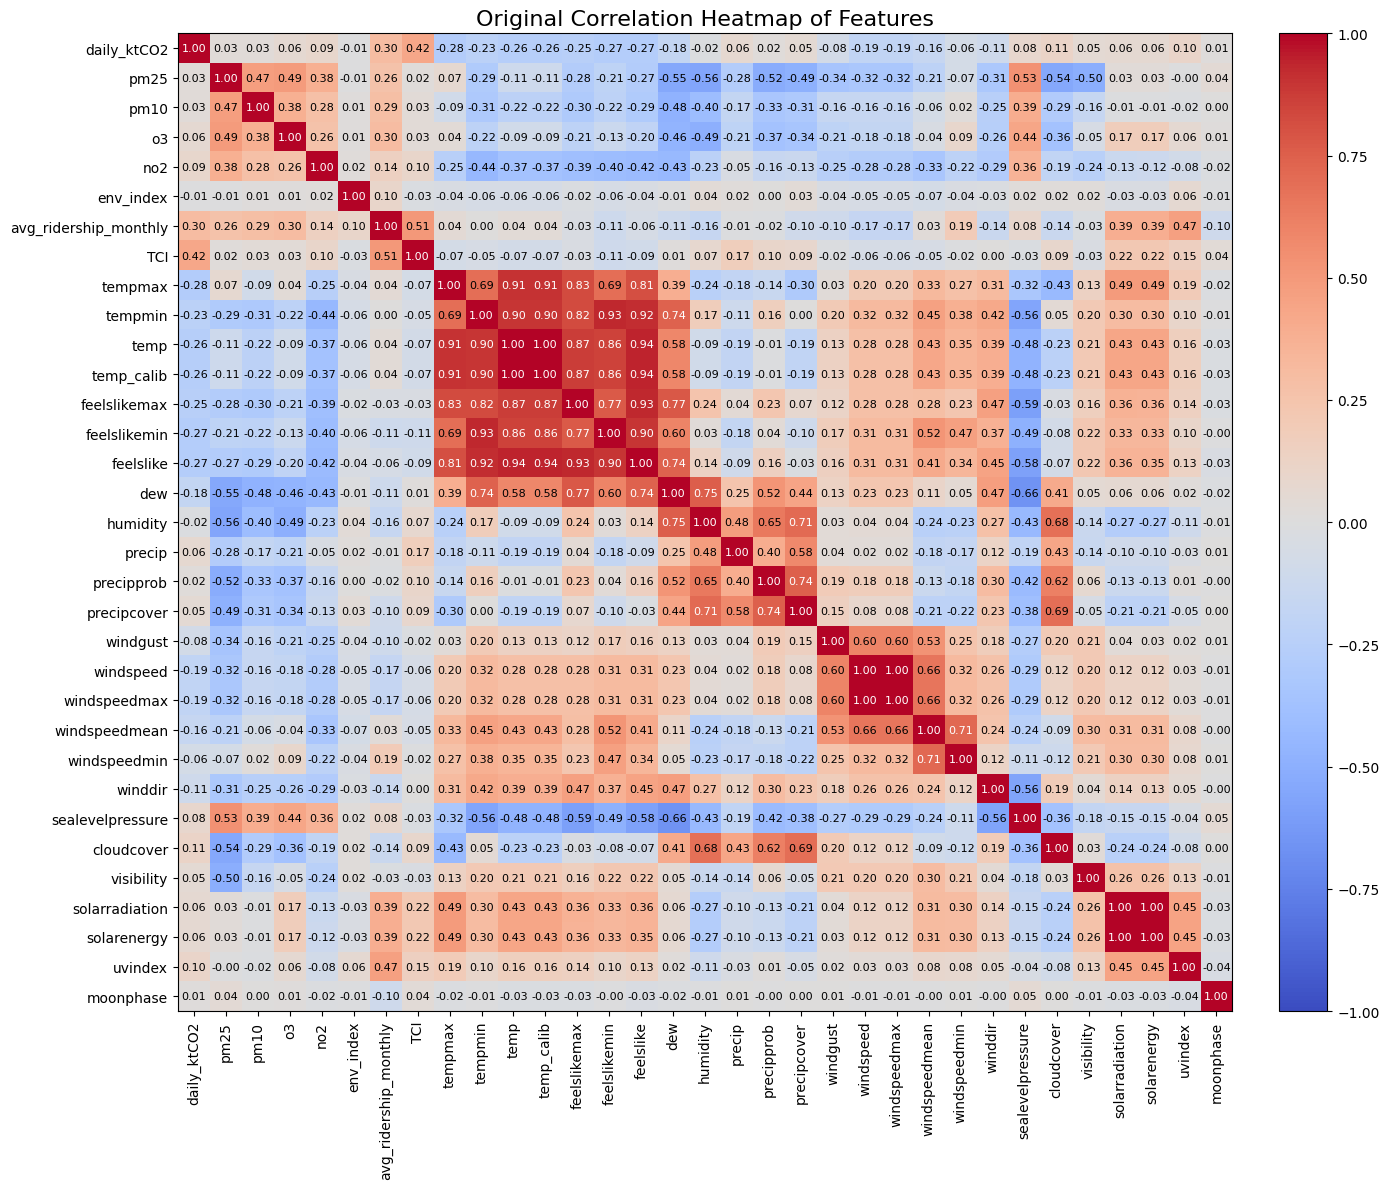

In [8]:
# Calculate correlation matrix
corr = df.select_dtypes(include=["number", "boolean"]).corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 12))
im = plt.imshow(corr, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90)
plt.yticks(ticks, corr.columns)

# Annotate heatmap with values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(
            j, i,
            f"{corr.iloc[i, j]:.2f}",  # format with 2 decimals
            ha="center", va="center",
            color="black" if abs(corr.iloc[i, j]) < 0.7 else "white",  # contrast
            fontsize=8
        )

plt.title("Original Correlation Heatmap of Features", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
high_correlation_cols = ['temp_calib', 'feelslikemax', 'feelslikemin', 'rain']

df.drop(columns=high_correlation_cols, inplace=True)
df2.drop(columns=high_correlation_cols, inplace=True)

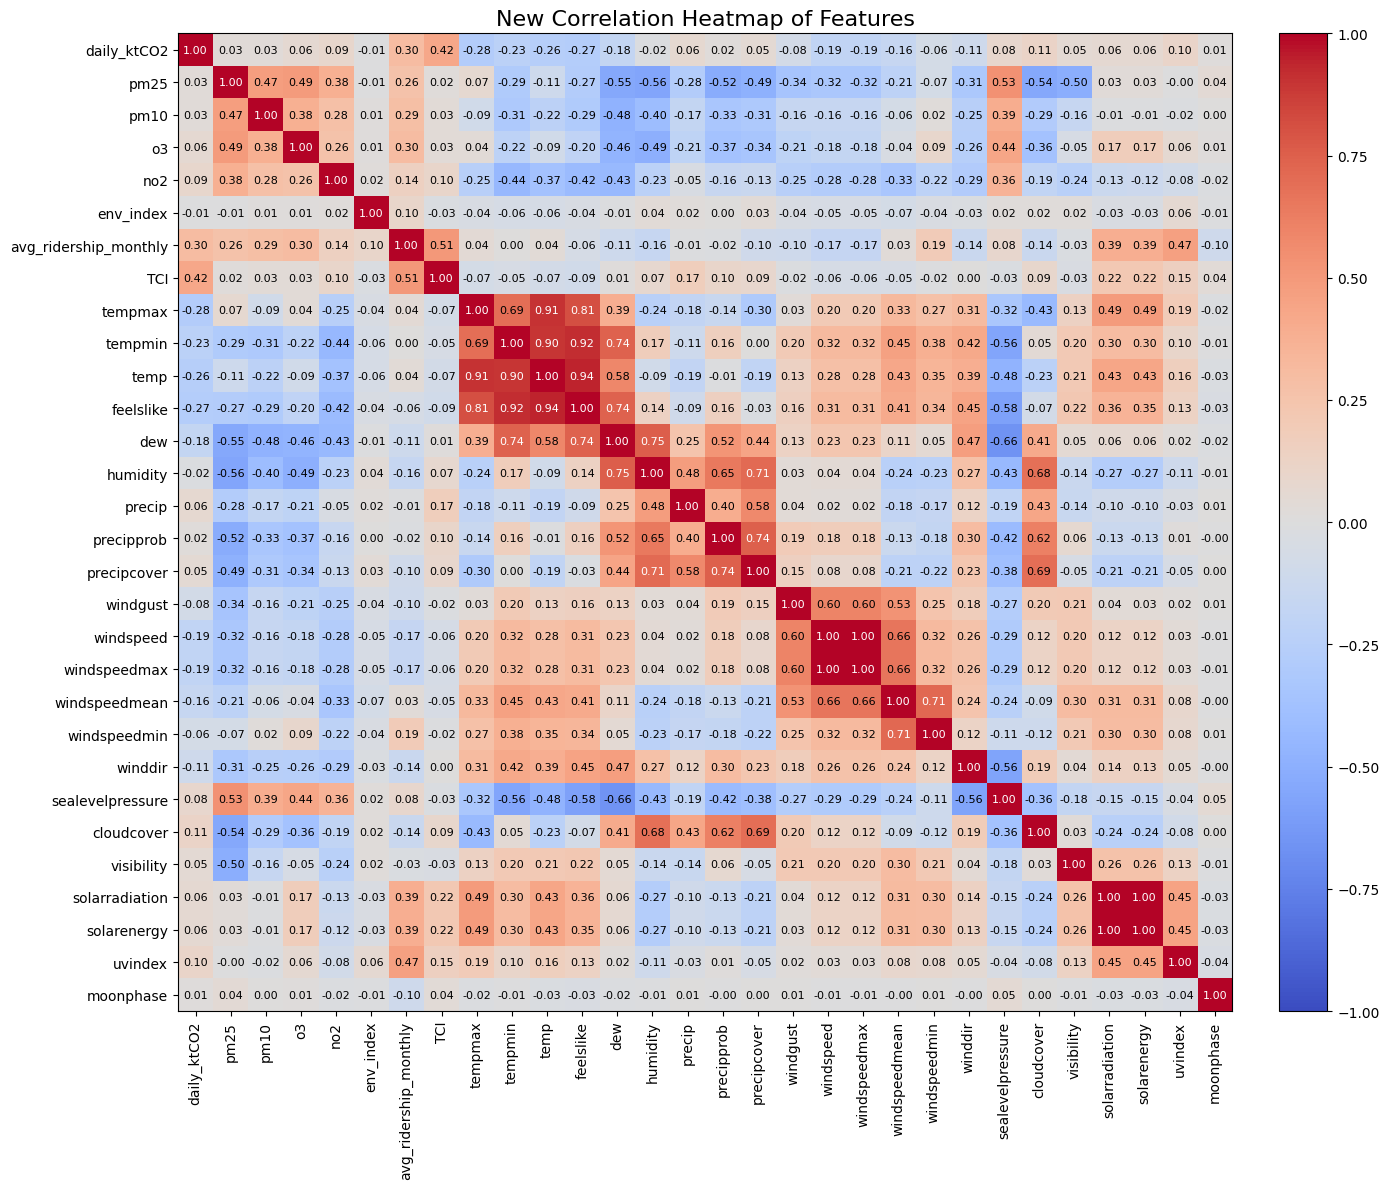

In [10]:
# Calculate correlation matrix
corr = df.select_dtypes(include=["number", "boolean"]).corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(14, 12))
im = plt.imshow(corr, cmap="coolwarm", aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)

ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90)
plt.yticks(ticks, corr.columns)

# Annotate heatmap with values
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(
            j, i,
            f"{corr.iloc[i, j]:.2f}",  # format with 2 decimals
            ha="center", va="center",
            color="black" if abs(corr.iloc[i, j]) < 0.7 else "white",  # contrast
            fontsize=8
        )

plt.title("New Correlation Heatmap of Features", fontsize=16)
plt.tight_layout()
plt.show()

#### 1.1.1.4 Cleaning data via dates

In [11]:
# Ekstrak fitur waktu dari 'date' (belum ngedrop 'date' dulu supaya aman)
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["dayofweek"] = df["date"].dt.dayofweek

if "date" in df2.columns:
    df2["date"] = pd.to_datetime(df2["date"], errors="coerce")
    df2["year"] = df2["date"].dt.year
    df2["month"] = df2["date"].dt.month
    df2["dayofweek"] = df2["date"].dt.dayofweek

# Benerin missing values buat weekend
df['weekend'] = df['date'].dt.dayofweek.isin([5, 6])
df2['weekend'] = df2['date'].dt.dayofweek.isin([5, 6])

#### 1.1.1.5 Fill in other NaN & remove outliers

In [12]:
df = df.set_index("date").sort_index()
df2 = df2.set_index("date").sort_index()

In [13]:
# Interpolate pm25 over time
df["pm25"] = df["pm25"].interpolate(method="time", limit_direction="both")
df["pm25"] = df["pm25"].fillna(df2["pm25"].median())

df2["pm25"] = df2["pm25"].interpolate(method="time", limit_direction="both")
df2["pm25"] = df2["pm25"].fillna(df2["pm25"].median())

# Interpolate pm10 over time
df["pm10"] = df["pm10"].interpolate(method="time", limit_direction="both")
df["pm10"] = df["pm10"].fillna(df["pm10"].median())

df2["pm10"] = df2["pm10"].interpolate(method="time", limit_direction="both")
df2["pm10"] = df2["pm10"].fillna(df2["pm10"].median())

# Interpolate o3 over time
df["o3"] = df["o3"].interpolate(method="time", limit_direction="both")
df["o3"] = df["o3"].fillna(df["o3"].median())

df2["o3"] = df2["o3"].interpolate(method="time", limit_direction="both")
df2["o3"] = df2["o3"].fillna(df2["o3"].median())

# Interpolate no2 over time
df["no2"] = df["no2"].interpolate(method="time", limit_direction="both")
df["no2"] = df["no2"].fillna(df["no2"].median())

df2["no2"] = df2["no2"].interpolate(method="time", limit_direction="both")
df2["no2"] = df2["no2"].fillna(df2["no2"].median())

# Interpolate uvindex over time
df["uvindex"] = df["uvindex"].interpolate(method="time", limit_direction="both")
df["uvindex"] = df["uvindex"].fillna(df["uvindex"].median())

df2["uvindex"] = df2["uvindex"].interpolate(method="time", limit_direction="both")
df2["uvindex"] = df2["uvindex"].fillna(df2["uvindex"].median())

In [14]:
# Fix moonphase
phys_out = ~df["moonphase"].between(0, 1, inclusive="both")
Q1, Q3 = df["moonphase"].quantile([0.25, 0.75])
IQR = Q3 - Q1
iqr_out = (df["moonphase"] < (Q1 - 1.5*IQR)) | (df["moonphase"] > (Q3 + 1.5*IQR))
outliers = phys_out | iqr_out

df["moonphase_clean"] = df["moonphase"].where(~outliers, np.nan)
df["moonphase_clean"] = df["moonphase_clean"].interpolate(method="time", limit_direction="both")

roll_med_df = df["moonphase"].where(~outliers, np.nan).rolling(window=15, center=True, min_periods=1).median()
df["moonphase_clean"] = df["moonphase_clean"].fillna(roll_med_df)
df["moonphase_clean"] = df["moonphase_clean"].ffill().bfill().clip(0, 1)

df["moonphase"] = df["moonphase_clean"]
df.drop(columns=["moonphase_clean"], inplace=True)

phys_out2 = ~df2["moonphase"].between(0, 1, inclusive="both")
Q1_2, Q3_2 = df2["moonphase"].quantile([0.25, 0.75])
IQR2 = Q3_2 - Q1_2
iqr_out2 = (df2["moonphase"] < (Q1_2 - 1.5*IQR2)) | (df2["moonphase"] > (Q3_2 + 1.5*IQR2))
outliers2 = phys_out2 | iqr_out2

df2["moonphase_clean"] = df2["moonphase"].where(~outliers2, np.nan)
df2["moonphase_clean"] = df2["moonphase_clean"].interpolate(method="time", limit_direction="both")

roll_med_df2 = df2["moonphase"].where(~outliers2, np.nan).rolling(window=15, center=True, min_periods=1).median()
df2["moonphase_clean"] = df2["moonphase_clean"].fillna(roll_med_df2)
df2["moonphase_clean"] = df2["moonphase_clean"].ffill().bfill().clip(0, 1)

df2["moonphase"] = df2["moonphase_clean"]
df2.drop(columns=["moonphase_clean"], inplace=True)

In [15]:
# Fill NaN in TCI
if "TCI" in df.columns:
    df["TCI"] = (
        df["TCI"].ffill().bfill().fillna(df["TCI"].median()))

if "TCI" in df2.columns:
    df2["TCI"] = df2["TCI"].fillna(df["TCI"].median())


In [16]:
# Fix avg_ridership_monthly
month_map = (
    df.dropna(subset=["avg_ridership_monthly"])
      .sort_values("date")
      .groupby("month")["avg_ridership_monthly"]
      .first()
)
global_med = df["avg_ridership_monthly"].median()

for d in (df, df2):
    d["avg_ridership_monthly"] = (
        d["avg_ridership_monthly"]
        .fillna(d["month"].map(month_map))
        .fillna(global_med)
    )


In [17]:
df = df.reset_index()
df2 = df2.reset_index()

### 1.1.2 Text Data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1606 non-null   datetime64[ns]
 1   daily_ktCO2            1606 non-null   float64       
 2   pm25                   1606 non-null   float64       
 3   pm10                   1606 non-null   float64       
 4   o3                     1606 non-null   float64       
 5   no2                    1606 non-null   float64       
 6   env_index              1606 non-null   float64       
 7   avg_ridership_monthly  1606 non-null   float64       
 8   TCI                    1606 non-null   float64       
 9   tempmax                1606 non-null   float64       
 10  tempmin                1606 non-null   float64       
 11  temp                   1606 non-null   float64       
 12  feelslike              1606 non-null   float64       
 13  dew

In [19]:
# Holiday via Regex
print(df['holiday'].unique())

df["holiday"] = (
    df["holiday"]
    .astype(str)                # ubah ke string biar bisa diproses
    .str.strip()                # hilangkan spasi depan/belakang
    .str.lower()                # jadi huruf kecil semua
    .replace("nan", np.nan)     # kembalikan 'nan' string jadi NaN
)

df2["holiday"] = (
    df["holiday"]
    .astype(str)                # ubah ke string biar bisa diproses
    .str.strip()                # hilangkan spasi depan/belakang
    .str.lower()                # jadi huruf kecil semua
    .replace("nan", np.nan)     # kembalikan 'nan' string jadi NaN
)

print(df["holiday"].unique())

['Yes' 'No' nan 'nO' 'yEs' 'no' 'NO' 'yes' 'yES' 'YeS' 'yeS' 'YES' 'YEs']
['yes' 'no' nan]


In [20]:
# Indonesia holiday calendar
import holidays

id_holidays = holidays.country_holidays("ID")

def fill_holiday(d):
    # Normalize existing values
    def map_yes_no(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().lower()
        if s == "yes": return True
        if s == "no":  return False
        return np.nan

    # map existing column
    holiday_bool = d["holiday"].map(map_yes_no)
    # fallback to official holiday boolean
    holiday_filled = holiday_bool.fillna(d["date"].dt.date.isin(id_holidays))
    return holiday_filled

df["holiday"]  = fill_holiday(df)
df2["holiday"] = fill_holiday(df2)

/tmp/ipython-input-458541286.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  holiday_filled = holiday_bool.fillna(d["date"].dt.date.isin(id_holidays))


In [21]:
# Seasons via Regex
df["seasons"] = (
    df["seasons"]
    .astype(str)                # ubah ke string biar bisa diproses
    .str.strip()                # hilangkan spasi depan/belakang
    .str.lower()                # jadi huruf kecil semua
    .replace("nan", np.nan)     # kembalikan 'nan' string jadi NaN
)

df2["seasons"] = (
    df["seasons"]
    .astype(str)                # ubah ke string biar bisa diproses
    .str.strip()                # hilangkan spasi depan/belakang
    .str.lower()                # jadi huruf kecil semua
    .replace("nan", np.nan)     # kembalikan 'nan' string jadi NaN
)


# Opsional: standarisasi ke bentuk Title Case (Cool, Hot, Rainy)
df["seasons"] = df["seasons"].replace({
    r"^cool$": "Cool",
    r"^hot$": "Hot",
    r"^rainy$": "Rainy"
}, regex=True)

df2["seasons"] = df2["seasons"].replace({
    r"^cool$": "Cool",
    r"^hot$": "Hot",
    r"^rainy$": "Rainy"
}, regex=True)

print(df["seasons"].unique())

# Fill missing based on most common season per month
season_map = df.groupby("month")["seasons"].agg(lambda x: x.mode()[0])
df.loc[df["seasons"].isna(), "seasons"] = df.loc[df["seasons"].isna(), "month"].map(season_map)

season_map = df2.groupby("month")["seasons"].agg(lambda x: x.mode()[0])
df2.loc[df["seasons"].isna(), "seasons"] = df2.loc[df2["seasons"].isna(), "month"].map(season_map)

[nan 'Cool' 'Hot' 'Rainy']


In [22]:

# --- 1) Normalize 'conditions' with regex (handle crazy capitalization/typos) ---
def normalize_conditions(val: object) -> object:
    if pd.isna(val):
        return np.nan

    s = str(val).strip().lower()

    # keep only letters, spaces, commas (drop other punctuation)
    s = re.sub(r"[^a-z,\s]", "", s)
    # collapse multiple spaces
    s = re.sub(r"\s+", " ", s)

    # detectors (very tolerant)
    has_rain = bool(re.search(r"\brain\b", s))
    has_pcloudy = bool(re.search(r"\b(part(?:ial)?(?:ly)?\s*cloudy)\b|partial.*cloudy", s))
    has_clear = bool(re.search(r"\bclear\b", s))

    labels = []
    # priority order: Rain > Partially cloudy > Clear
    if has_rain:
        labels.append("Rain")
    if has_pcloudy:
        labels.append("Partially cloudy")
    # only add "Clear" if no other weather already detected
    if has_clear and not labels:
        labels.append("Clear")

    if not labels:
        return np.nan  # if nothing matched, leave as missing
    return ", ".join(labels)

# apply normalization
df["conditions"] = df["conditions"].apply(normalize_conditions)

df2["conditions"] = df2["conditions"].apply(normalize_conditions)

# --- 2) Fill NaN using the previous data point in time (forward-fill) ---
# make sure we have a proper DatetimeIndex ordered by time
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.sort_values("date").set_index("date")

df2["date"] = pd.to_datetime(df2["date"], errors="coerce")
df2 = df2.sort_values("date").set_index("date")

# forward fill only the 'conditions' column
df["conditions"] = df["conditions"].ffill()

df2["conditions"] = df2["conditions"].ffill()

# (optional) restore 'date' as a normal column
df = df.reset_index()

df2 = df2.reset_index()

# sanity check
print(df["conditions"].unique()[:10])

['Partially cloudy' 'Clear' 'Rain, Partially cloudy']


## 1.2 Fixing Data Types

In [23]:
df["weekend"] = df["weekend"].astype(int)
df["holiday"] = df["holiday"].astype(int)

df2["weekend"] = df2["weekend"].astype(int)
df2["holiday"] = df2["holiday"].astype(int)

## 1.3 One hot encoding

In [24]:
df = pd.get_dummies(df, columns=["conditions","seasons"], drop_first=True)
df2 = pd.get_dummies(df2, columns=["conditions","seasons"], drop_first=True)

df['conditions_Partially cloudy'] = df['conditions_Partially cloudy'].astype(int)
df['conditions_Rain, Partially cloudy'] = df['conditions_Rain, Partially cloudy'].astype(int)
df['seasons_Hot'] = df['seasons_Hot'].astype(int)
df['seasons_Rainy'] = df['seasons_Rainy'].astype(int)

df2['conditions_Partially cloudy'] = df2['conditions_Partially cloudy'].astype(int)
df2['conditions_Rain, Partially cloudy'] = df2['conditions_Rain, Partially cloudy'].astype(int)
df2['seasons_Hot'] = df2['seasons_Hot'].astype(int)
df2['seasons_Rainy'] = df2['seasons_Rainy'].astype(int)

In [25]:
final = df.copy()
final_test = df2.copy()
final_test_date = df2.copy()

In [26]:
final.drop(columns=['date'], inplace=True)
final_test.drop(columns=['date'], inplace=True)

In [27]:
#final.to_csv("final.csv", index=False)
#final_test.to_csv("final_test.csv", index=False)
#final_test_date.to_csv("final_test_date.csv", index=False)

#files.download("final.csv")
#files.download("final_test.csv")
#files.download("final_test_date.csv")

## 1.4 Feature Engineering

In [28]:
df["monthly_pm25"] = df.groupby(df["date"].dt.month)["pm25"].transform("mean")
df["relative_pm25"] = df["pm25"] / df["monthly_pm25"]

df2["monthly_pm25"] = df2.groupby(df2["date"].dt.month)["pm25"].transform("mean")
df2["relative_pm25"] = df2["pm25"] / df2["monthly_pm25"]

# 2. Preprocessing

## 2.1 Train Test Split

In [29]:
# Drop kolom yang tidak dipakai dulu dari df
TARGET = "daily_ktCO2"
y = final[TARGET]
X = final.drop(columns=[TARGET]).copy()

In [30]:
X

,pm25,pm10,o3,no2,env_index,avg_ridership_monthly,TCI,tempmax,tempmin,temp,...,moonphase,weekend,holiday,year,month,dayofweek,conditions_Partially cloudy,"conditions_Rain, Partially cloudy",seasons_Hot,seasons_Rainy
0,74.0,46.0,11.0,15.0,0.506768,397.0,12.70,32.4,25.2,28.8,...,0.19,0,1,2020,1,2,1,0,0,0
1,93.0,52.0,12.0,18.0,0.673507,397.0,8.04,32.8,24.5,28.5,...,0.22,0,0,2020,1,3,1,0,0,0
2,102.0,56.0,16.0,18.0,0.440693,397.0,16.38,33.5,24.2,28.7,...,0.25,0,0,2020,1,4,1,0,0,0
3,121.0,61.0,15.0,17.0,0.109702,397.0,13.17,33.3,23.7,28.7,...,0.29,1,1,2020,1,5,1,0,0,0
4,130.0,66.0,14.0,27.0,0.643137,397.0,9.00,33.6,25.0,28.9,...,0.32,1,1,2020,1,6,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,64.0,26.0,23.0,1.0,0.620641,119.0,59.66,35.5,26.2,30.4,...,0.39,0,0,2024,5,0,0,1,1,0
1602,56.0,26.0,11.0,1.0,0.005331,119.0,59.66,33.0,26.4,29.4,...,0.42,0,0,2024,5,1,0,1,1,0
1603,53.0,23.0,9.0,1.0,0.847391,119.0,59.66,34.0,26.6,29.6,...,0.46,0,0,2024,5,2,0,1,1,0
1604,50.0,18.0,20.0,1.0,0.958030,119.0,59.66,30.6,26.2,28.0,...,0.50,0,0,2024,5,3,0,1,1,0


In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1606 entries, 0 to 1605
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pm25                               1606 non-null   float64
 1   pm10                               1606 non-null   float64
 2   o3                                 1606 non-null   float64
 3   no2                                1606 non-null   float64
 4   env_index                          1606 non-null   float64
 5   avg_ridership_monthly              1606 non-null   float64
 6   TCI                                1606 non-null   float64
 7   tempmax                            1606 non-null   float64
 8   tempmin                            1606 non-null   float64
 9   temp                               1606 non-null   float64
 10  feelslike                          1606 non-null   float64
 11  dew                                1606 non-null   float

In [32]:
final_test

,pm25,pm10,o3,no2,env_index,avg_ridership_monthly,TCI,tempmax,tempmin,temp,...,moonphase,weekend,holiday,year,month,dayofweek,conditions_Partially cloudy,"conditions_Rain, Partially cloudy",seasons_Hot,seasons_Rainy
0,50.0,24.0,11.0,1.0,0.064032,119.0,23.43,34.4,27.5,30.3,...,0.560000,1,1,2024,5,5,0,1,0,0
1,42.0,26.0,11.0,1.0,0.778897,119.0,23.43,34.2,25.6,30.0,...,0.550886,1,0,2024,5,6,0,1,0,0
2,52.0,27.0,9.0,1.0,0.579115,119.0,23.43,35.5,25.9,30.7,...,0.630000,0,0,2024,5,0,0,1,0,0
3,59.0,32.0,9.0,1.0,0.410545,119.0,23.43,35.6,27.3,31.6,...,0.665000,0,1,2024,5,1,0,1,0,0
4,59.0,30.0,10.0,1.0,0.764583,119.0,23.43,34.9,28.7,31.9,...,0.700000,0,1,2024,5,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,61.0,24.0,7.0,1.0,0.252989,203.0,23.43,94.0,82.9,87.9,...,0.020000,0,0,2025,6,3,0,1,0,0
398,55.0,31.0,7.0,1.0,0.518942,203.0,23.43,90.5,76.7,83.8,...,0.060000,0,0,2025,6,4,0,1,0,0
399,69.0,26.0,7.0,1.0,0.980781,203.0,23.43,90.1,78.4,82.5,...,0.090000,1,0,2025,6,5,0,1,0,0
400,61.0,29.0,7.0,1.0,0.187222,203.0,23.43,91.3,75.4,81.5,...,0.120000,1,0,2025,6,6,0,1,0,0


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False   # shuffle=False preserves time order
)

## 2.2 Scaling

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(final_test)
X_test_scaled = scaler.transform(X_test)

# 3. Model Building, Prediction, and Evaluation

## 3.1 Individual Machine Learning Model

### 3.1.2 LightGBM

In [35]:
# ---- pick scaled/unscaled safely ----
try:
    Xtr = X_train_scaled
except NameError:
    Xtr = X_train

try:
    Xte = X_test_scaled
except NameError:
    Xte = X_test

# Convert to NumPy to avoid feature-name issues in LightGBM
Xtr_np = Xtr.to_numpy() if hasattr(Xtr, "to_numpy") else np.asarray(Xtr)
Xte_np = Xte.to_numpy() if hasattr(Xte, "to_numpy") else np.asarray(Xte)
ytr_np = np.asarray(y_train).ravel()
yte_np = np.asarray(y_test).ravel()

best_lgb_model = LGBMRegressor(
    num_leaves=5,
    min_data_in_leaf=44,
    learning_rate=0.05,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l2=0.1,
    n_estimators=550,
    max_depth=-1,
    random_state=42,
    verbosity=-1
    )
best_lgb_model.fit(Xtr_np, ytr_np)

# ---- predictions ----
y_train_pred_lgb = best_lgb_model.predict(Xtr_np)
y_test_pred_lgb  = best_lgb_model.predict(Xte_np)

# ---- metrics (no sklearn 'squared=False' needed) ----
rmse_lgb_train = np.sqrt(mean_squared_error(ytr_np, y_train_pred_lgb))
r2_lgb_train   = r2_score(ytr_np, y_train_pred_lgb)

rmse_lgb_test  = np.sqrt(mean_squared_error(yte_np, y_test_pred_lgb))
r2_lgb_test    = r2_score(yte_np, y_test_pred_lgb)

# Normalized RMSE (% of range)
range_train = (np.max(ytr_np) - np.min(ytr_np)) or 1.0
range_test  = (np.max(yte_np) - np.min(yte_np)) or 1.0
nrmse_train = (rmse_lgb_train / range_train) * 100
nrmse_test  = (rmse_lgb_test  / range_test)  * 100

# MAPE with safe denominator (avoid division by zero)
eps = 1e-8
mape_train = np.mean(np.abs((ytr_np - y_train_pred_lgb) / np.where(np.abs(ytr_np) < eps, eps, np.abs(ytr_np)))) * 100
mape_test  = np.mean(np.abs((yte_np  - y_test_pred_lgb ) / np.where(np.abs(yte_np)  < eps, eps, np.abs(yte_np))))  * 100

# ---- print in your exact style ----
print(f"LightGBM - Training Root Mean Squared Error: {rmse_lgb_train:.4f}")
print(f"LightGBM - Training R-squared: {r2_lgb_train:.4f}")

print(f"LightGBM - Test Root Mean Squared Error: {rmse_lgb_test:.4f}")
print(f"LightGBM - Test R-squared: {r2_lgb_test:.4f}")

print(f"Train NRMSE: {nrmse_train:.2f}%")
print(f"Test NRMSE: {nrmse_test:.2f}%")
print(f"Train MAPE: {mape_train:.2f}%")
print(f"Test MAPE: {mape_test:.2f}%")


LightGBM - Training Root Mean Squared Error: 1.3819
LightGBM - Training R-squared: 0.9438
LightGBM - Test Root Mean Squared Error: 1.9494
LightGBM - Test R-squared: 0.7712
Train NRMSE: 4.25%
Test NRMSE: 6.99%
Train MAPE: 2.25%
Test MAPE: 2.78%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [36]:
# Prediction for validation dataset
y_val_pred = best_lgb_model.predict(X_val_scaled)

val_output = pd.DataFrame({
    "date": final_test_date["date"],
    "daily_ktCO2": y_val_pred
})

# Show the first 20 predictions
print(val_output)

          date  daily_ktCO2
0   2024-05-25    48.086326
1   2024-05-26    47.644951
2   2024-05-27    49.973990
3   2024-05-28    49.800176
4   2024-05-29    50.530117
..         ...          ...
397 2025-06-26    52.113880
398 2025-06-27    51.091480
399 2025-06-28    50.075803
400 2025-06-29    48.990260
401 2025-06-30    50.370095

[402 rows x 2 columns]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# 4. Download CSV File

In [37]:
val_output["date"] = val_output["date"].dt.strftime("%-m/%-d/%Y")
val_output.to_csv("submission.csv", index=False)

# Download to your computer
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>